In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os, json, cv2
import tensorflow as tf

import efficientnet.tfkeras as efn
from efficientnet.preprocessing import center_crop_and_resize

from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from tensorflow.keras.layers import Input, Dense, Flatten, ReLU, LeakyReLU,\
            Dropout, BatchNormalization, GlobalAvgPool2D, GlobalMaxPool2D
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import CategoricalAccuracy, Accuracy

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split
import albumentations as A

In [2]:
WORK_DIR = "./data/"
os.listdir(WORK_DIR)

with open(os.path.join(WORK_DIR, 'label_num_to_disease_map.json'), 'r') as file:
    labels = json.load(file)

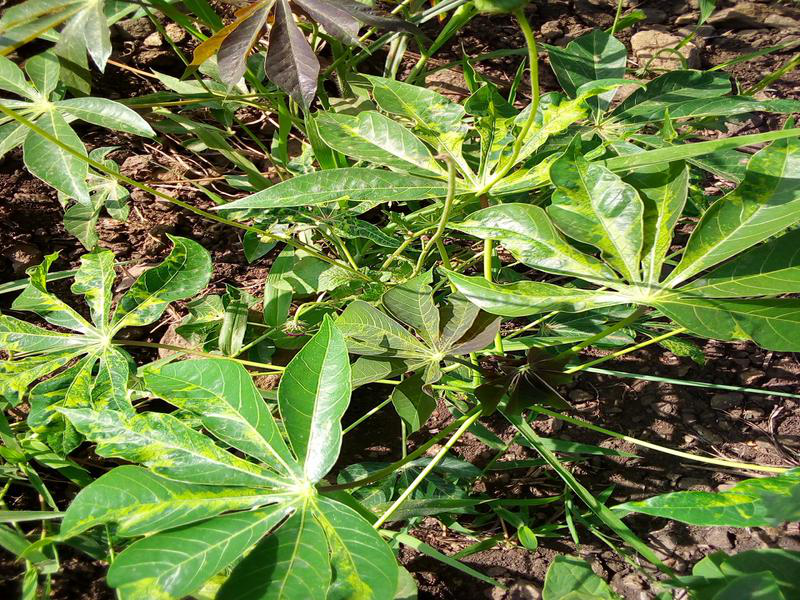

In [3]:
#Test random image 
data = pd.read_csv(os.path.join(WORK_DIR, 'train.csv'))
rand_idx = np.random.randint(data.shape[0])
rand_fname = data.iloc[rand_idx, 0]
train_images_folder = '/home/sm00th/Projects/cassava/data/train_images'
rand_fpath = os.path.join(train_images_folder, rand_fname)

Image.open(rand_fpath)

In [4]:
# Classes balancer
from sklearn.utils import class_weight


class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(data.label),
                                                 data.label)

cls_weights = dict(data.label.value_counts() / data.shape[0]);
cls_weights

/home/sm00th/anaconda3/envs/cassava/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass classes=[0 1 2 3 4], y=0        0
1        3
2        1
3        1
4        3
        ..
21392    3
21393    3
21394    1
21395    4
21396    4
Name: label, Length: 21397, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


{3: 0.6149460204701593,
 4: 0.12043744450156564,
 2: 0.11151095948030097,
 1: 0.10230406131700706,
 0: 0.05080151423096696}

### Make batch generator

In [5]:
class MyGeneratorUnWeighted(Sequence):
    def __init__(self, x, y, 
                 batch_size, 
                 img_size, 
                 num_classes,
                 augment_img,
                 img_preproc=False):
        self.x, self.y = x, y
        self.img_height, self.img_width = img_size
        self.batch_size = batch_size
        self.img_preproc = img_preproc
        self.augment_img = augment_img
        self.num_classes = num_classes

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))
    
    def _augment(self, img):
        transform = A.Compose([
            A.RandomCrop(p=0.5,
                         width=int(self.img_width / 1.3), 
                         height=int(self.img_height / 1.3)),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomBrightnessContrast(p=0.2, 
                                      brightness_limit=0.1,
                                      contrast_limit=0.1),
            A.ShiftScaleRotate(p=0.5),
            A.RandomRotate90(),
#             A.Blur(p=0.2, blur_limit=3),
#             A.OpticalDistortion(distort_limit=0.2,
#                                 shift_limit=0.05,
#                                 border_mode=4),
#             A.GridDistortion(distort_limit=0.2, 
#                              border_mode=4),
#             A.HueSaturationValue(hue_shift_limit=15,
#                                  sat_shift_limit=30,
#                                  val_shift_limit=40,),
#             A.CLAHE(),
#             A.ImageCompression(quality_lower=85),
        ])
        return transform(image=img)['image']
        
    def preproc_imgs(self, img):
        img = img / 255
        imagenet_mean = 0.485, 0.456, 0.406,
        imagenet_std = [0.229, 0.224, 0.225]
        img = (img - np.tile(imagenet_mean, (self.img_height, self.img_width, 1))) /\
                     np.tile(imagenet_std, (self.img_height, self.img_width, 1))
        return img


    def __getitem__(self, idx):
        batch_x = np.zeros((self.batch_size, self.img_height, self.img_width, 3))
        batch_y = np.zeros(self.batch_size)
        
        x = self.x[idx * self.batch_size: (idx + 1) * self.batch_size]
        y = self.y[idx * self.batch_size: (idx + 1) * self.batch_size]
        
        for n, (i, l) in enumerate(zip(x, y)):
            img = load_img(os.path.join(train_images_folder, i))
            img = img_to_array(img, dtype='uint8')
            
            if self.augment_img:
                img = self._augment(img)
                
            img = cv2.resize(img, (self.img_height, self.img_width))
            
            if self.img_preproc:
                img = self.preproc_imgs(img)
                
            batch_x[n] = img
            batch_y[n] = l
            
        return batch_x, to_categorical(batch_y, 
                        num_classes=self.num_classes), [None]

### Baseline

In [6]:
x_train, x_test, y_train, y_test =\
        train_test_split(data.image_id, data.label, test_size=0.15)

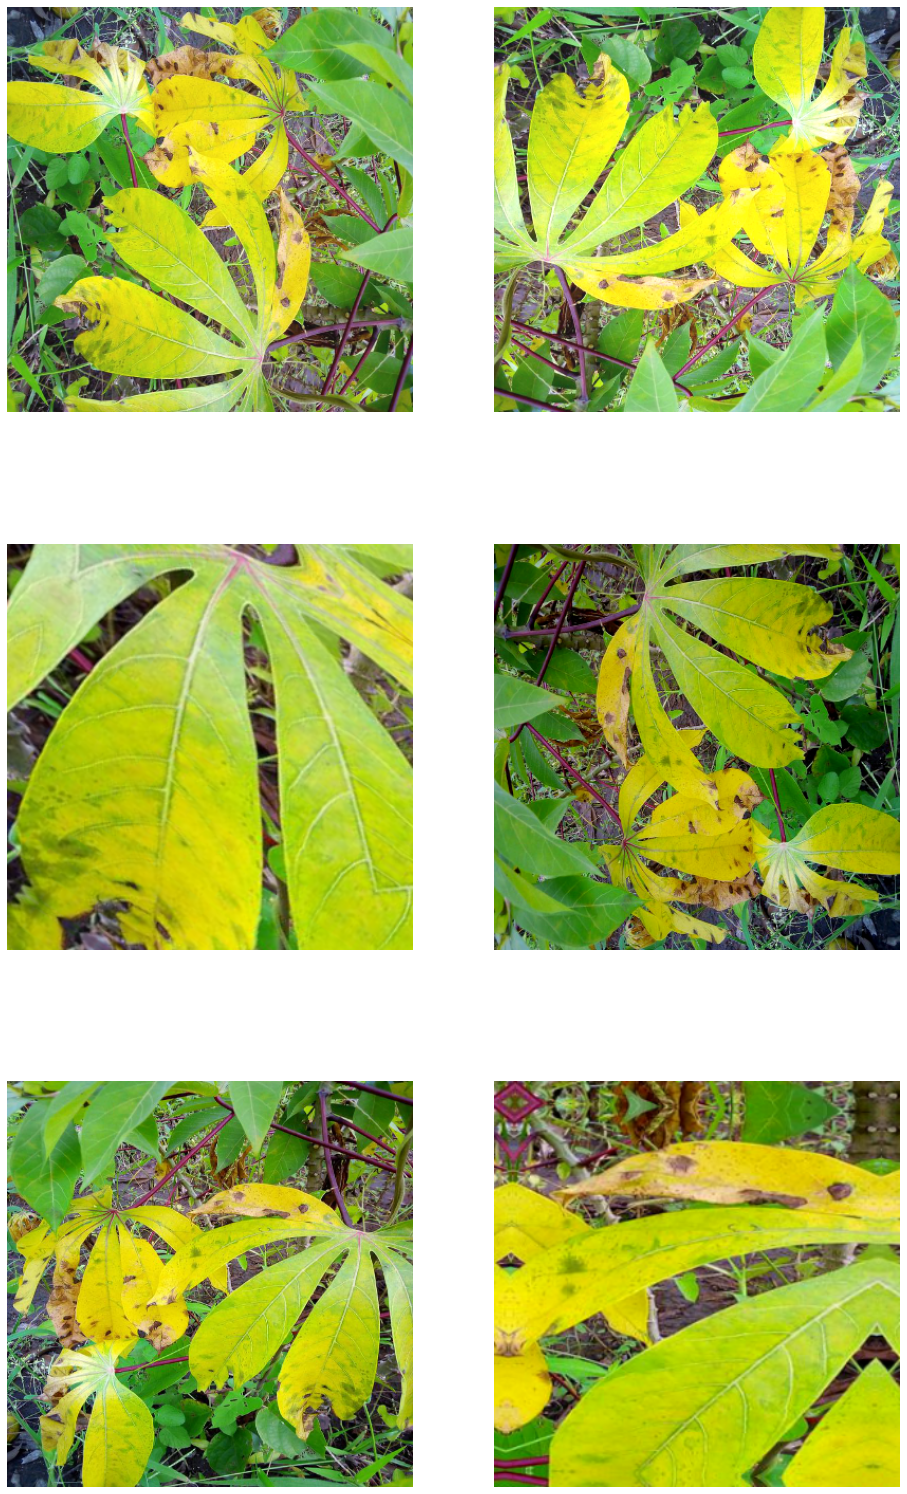

In [7]:
# Augmentation setting up
plt.figure(figsize=(16, 28))

for n in range(6):
    plt.subplot(3, 2, n+1)
    
    check_gen = MyGeneratorUnWeighted(x_train, y_train, 
                                   batch_size=1, 
                                   img_preproc=None,
                                   augment_img=True,
                                   num_classes=5,
                                   img_size=(384, 384))
    
    check_img = check_gen.__getitem__(0)[0][0] / 255

    plt.imshow(check_img);
    plt.axis('off')
plt.show();

In [8]:
net_cfg = {
    'num_classes': 5,
    'img_height': 512,
    'img_width': 512,
    'img_channels': 3,
    'batch_size': 4,
    'backbone': efn.EfficientNetB3(include_top=False),
    'preproc_img': True,
    'augment_img': True,
    'num_epochs': 10,
    'class_weights': class_weights,
    'backbone_trainable': True,
    'use_dropout': True,
    'activation': ReLU(),
    'opt': Adam(lr=0.0001),
    'criterion': CategoricalCrossentropy(),
    'metrics': [CategoricalAccuracy()]
}

In [9]:
class CassavaNet():
    def __init__(self, model_name, net_cfg, 
                 x_train, y_train,
                 x_test, y_test):
        self.model_name = model_name
        self.num_classes = net_cfg['num_classes']
        self.batch_size = net_cfg['batch_size']
        self.img_height = net_cfg['img_height']
        self.img_width = net_cfg['img_width']
        self.img_channels = net_cfg['img_channels']
        self.preproc_img = net_cfg['preproc_img']
        self.augment_img = net_cfg['augment_img']
        self.backbone = net_cfg['backbone']
        self.backbone.trainable = net_cfg['backbone_trainable']
        
#         if self.backbone.trainable == False:
#             for i in range(len(self.backbone.layers)):
#                 if i > len(self.backbone.layers) - 21:
#                     self.backbone.layers[i].trainable = True
            
        inputs = Input(shape=(self.img_height, 
                              self.img_width, 
                              self.img_channels))
        
        x = BatchNormalization()(inputs)
    
        x = self.backbone(x)
        x = GlobalAvgPool2D()(x)
#         x = Dense(128)(x)
        
#         x = BatchNormalization()(x)
            
#         x = net_cfg['activation'](x)
        
#         if net_cfg['use_dropout']:
#             x = Dropout(0.05)(x)
            
#         x = Dense(64)(x)
        
#         x = BatchNormalization()(x)
            
#         x = net_cfg['activation'](x)
        
#         if net_cfg['use_dropout']:
#             x = Dropout(0.05)(x)
            
        x = Dense(64)(x)
        
        x = BatchNormalization()(x)
            
        x = net_cfg['activation'](x)
        
        if net_cfg['use_dropout']:
            x = Dropout(0.05)(x)

        outputs = Dense(self.num_classes, 
                        activation='softmax')(x)
    
        self.model = Model(inputs, outputs)
        self.opt = net_cfg['opt']
        self.criterion = net_cfg['criterion']
        self.metrics = net_cfg['metrics']
        self.class_weights = net_cfg['class_weights']
        
        cb_tensorboard = tf.keras.callbacks.TensorBoard(log_dir='./logs', )
        cb_checpoint = tf.keras.callbacks.ModelCheckpoint(filepath='weights.{epoch:02d}-{val_loss:.2f}.hdf5',
                                                      monitor='val_loss',
                                                      verbose=1,
                                                      save_best_only=True)
        cb_earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                        patience=3,
                                                        verbose=0,
                                                        restore_best_weights=True)
        self.callbacks = [cb_tensorboard, cb_checpoint]
        
        self.traingen = MyGeneratorUnWeighted(x_train, y_train, 
                               batch_size=self.batch_size, 
                               img_preproc=self.preproc_img,
                               augment_img=self.augment_img,
                               num_classes=self.num_classes,
                               img_size=(self.img_height, self.img_width))
        self.testgen = MyGeneratorUnWeighted(x_test, y_test,               
                              batch_size=self.batch_size, 
                              img_preproc=self.preproc_img,
                              augment_img=False,
                              num_classes=self.num_classes,
                              img_size=(self.img_height, self.img_width))
        
        print(self.model.summary())
            
    def _compile(self):
        self.model.compile(optimizer=self.opt, 
                           loss=self.criterion,
                           metrics=self.metrics)
    
    def train(self):
        self._compile()
        
        self.history = self.model.fit_generator(generator=self.traingen,                                 
                                    steps_per_epoch=self.traingen.__len__(),
                                    epochs=net_cfg['num_epochs'],
                                    validation_data=self.testgen,
                                    validation_steps=self.testgen.__len__(),
                                    workers=-1,
                                    callbacks=self.callbacks, 
                                    class_weight=self.class_weights
                                               )
        
    def visualize_batch(self):
        gentest_images, gentest_labels, _ = self.traingen.__getitem__(0)
        gentest_images = gentest_images[:16]

        plt.figure(figsize=(16, 16))

        for n, (i, l) in enumerate(zip(gentest_images, gentest_labels)):
            plt.subplot(4, 4, n+1)
            plt.imshow(i * 255 + 127.5)
            plt.axis('off')

        plt.show();
        
    def plot_hist(self):
        if self.history:
            plt.figure(figsize=(16, 16))
            fig, axes = plt.subplots(nrows=1, ncols=2)
            ax1, ax2 = axes
            
            ax1.plot(self.history.history['loss'],
                     label='Loss')
            ax1.plot(self.history.history['val_loss'],
                    label='Val Loss')
            ax1.legend()
            
            ax2.plot(self.history.history['categorical_accuracy'],
                     label='Categorical Accuracy')
            ax2.plot(self.history.history['val_categorical_accuracy'],
                    label='Val Categorical Accuracy')
            ax2.legend()
            
            plt.show();

In [10]:
cassava_net = CassavaNet('m1', net_cfg, 
                         x_train[:], y_train[:],
                         x_test, y_test)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
batch_normalization (BatchNo (None, 512, 512, 3)       12        
_________________________________________________________________
efficientnet-b3 (Model)      multiple                  10783528  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                98368     
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
re_lu (ReLU)                 (None, 64)                0     

In [ ]:
cassava_net.train()

Instructions for updating:
Please use Model.fit, which supports generators.
Train for 4547 steps, validate for 803 steps
Epoch 1/10
4546/4547 [============================>.] - ETA: 0s - loss: 0.8505 - categorical_accuracy: 0.6982
Epoch 00001: val_loss improved from inf to 0.47955, saving model to weights.01-0.48.hdf5
4547/4547 [==============================] - 1397s 307ms/step - loss: 0.8505 - categorical_accuracy: 0.6982 - val_loss: 0.4795 - val_categorical_accuracy: 0.8387
Epoch 2/10
4546/4547 [============================>.] - ETA: 0s - loss: 0.6368 - categorical_accuracy: 0.7873
Epoch 00002: val_loss improved from 0.47955 to 0.46591, saving model to weights.02-0.47.hdf5
4547/4547 [==============================] - 1391s 306ms/step - loss: 0.6368 - categorical_accuracy: 0.7873 - val_loss: 0.4659 - val_categorical_accuracy: 0.8512
Epoch 3/10
4546/4547 [============================>.] - ETA: 0s - loss: 0.5801 - categorical_accuracy: 0.8111
Epoch 00003: val_loss improved from 0.46591

In [ ]:
cassava_net.plot_hist()

In [ ]:
X, y = data.image_id.values, data.label.values
skf = StratifiedKFold(n_splits=5, random_state = 7, shuffle = True)

def get_model_name(k):
    return 'model_'+str(k)+'.h5'

for train_idx, val_idx in skf.split(X, y):
    print(train_idx, val_idx)